In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
from tqdm import tqdm
import sys
import tensorflow as tf
from keras import Input
from keras import layers, Model
from keras.applications import VGG19
from keras.layers import BatchNormalization, Activation, PReLU, LeakyReLU, Add, Dense, Input, Flatten
from keras.layers.convolutional import Conv2D, UpSampling2D
from sklearn.model_selection import train_test_split
from keras.models import load_model
from IPython.display import display, clear_output

In [2]:
#Model Control Panel
#N_img: Number of images from whole dataset
#N_data: Number of images to be tested on
#Dim_lr: Dimension of square low-res images
#Dim_hr: Dimension of square high-res images
#N_epoch: Number of epochs
#N_save: Number of epochs before generator is saved

N_img = 25000

N_data = 500

Dim_lr = 32

Dim_hr = 128

N_epoch = 20

N_save = 2

In [33]:
for i in tqdm(list(range(N_img))):
    num = str(i + 1)
    file = ''.join(["im", num])
    type = "jpg"
    im = '.'.join([file, type])
    path1 = r'C:\Users\bough\Documents\MDST\SuperRes\dataset\mirflickr'
    path = os.path.join(path1, im)
    image_BGR = cv.imread(path)
    
    width_hr = 128
    height_hr = 128
    scale_hr = (width_hr, height_hr)
    image_hr = cv.resize(image_BGR, scale_hr, interpolation= cv.INTER_CUBIC)
    
    hr_file = ''.join(["hr_im", num])
    hr_im = '.'.join([hr_file, type])
    path2 = r'C:\Users\bough\Documents\MDST\SuperRes\hr_dataset'
    os.chdir(path2)
    cv.imwrite(hr_im, image_hr)

100%|██████████| 25000/25000 [04:15<00:00, 98.00it/s] 


In [59]:
for i in tqdm(list(range(N_img))):
    num = str(i + 1)
    file = ''.join(["hr_im", num])
    type = "jpg"
    im = '.'.join([file, type])
    path1 = r'C:\Users\bough\Documents\MDST\SuperRes\hr_dataset'
    path = os.path.join(path1, im)
    image_BGR = cv.imread(path)
    
    width_lr = 32
    height_lr = 32
    scale_lr = (width_lr, height_lr)
    image_lr = cv.resize(image_BGR, scale_lr, interpolation= cv.INTER_AREA)
    
    lr_file = ''.join(["lr_im", num])
    lr_im = '.'.join([lr_file, type])
    path2 = r'C:\Users\bough\Documents\MDST\SuperRes\lr_dataset'
    os.chdir(path2)
    cv.imwrite(lr_im, image_lr)

100%|██████████| 25000/25000 [02:32<00:00, 164.14it/s]


In [3]:
hr_norm = []
for i in tqdm(list(range(N_data))):
    num = str(i + 1)
    file = ''.join(["hr_im", num])
    type = "jpg"
    im = '.'.join([file, type])
    path1 = r'C:\Users\bough\Documents\MDST\SuperRes\hr_dataset'
    path = os.path.join(path1, im)
    img =  np.array(plt.imread(path))
    hr_norm.append(img / 255)
print(sys.getsizeof(hr_norm))

100%|██████████| 500/500 [00:00<00:00, 593.52it/s]

4216


In [4]:
lr_norm = []
for i in tqdm(list(range(N_data))):
    num = str(i + 1)
    file = ''.join(["lr_im", num])
    type = "jpg"
    im = '.'.join([file, type])
    path1 = r'C:\Users\bough\Documents\MDST\SuperRes\lr_dataset'
    path = os.path.join(path1, im)
    img = np.array(plt.imread(path))
    lr_norm.append(img / 255)
print(sys.getsizeof(lr_norm))

100%|██████████| 500/500 [00:00<00:00, 1048.24it/s]

4216


In [5]:
lr_tens = []
hr_tens = []
for i in tqdm(list(range(N_data))):
        tensor_lr = tf.convert_to_tensor(lr_norm[i], dtype=float)
        lr_tens.append(tf.reshape(tensor_lr, (-1, Dim_lr, Dim_lr, 3)))
        tensor_hr = tf.convert_to_tensor(hr_norm[i], dtype=float)
        hr_tens.append(tf.reshape(tensor_hr, (-1, Dim_hr, Dim_hr, 3)))

100%|██████████| 500/500 [00:01<00:00, 380.07it/s]


In [6]:
lr_test, lr_train, hr_test, hr_train = train_test_split(lr_tens, hr_tens, test_size = 0.3, random_state = 0)

In [7]:
def residual_block(save):
 x = save
 x = Conv2D(64, (3, 3), strides = (1, 1), input_shape= (Dim_lr, Dim_lr, None), padding="same")(x)
 x = BatchNormalization()(x)
 x = PReLU()(x)
 x = Conv2D(64, (3, 3), strides = (1, 1), input_shape= (Dim_lr, Dim_lr, None), padding="same")(x)
 x = BatchNormalization()(x)
 return x + save

def generator(img):
 x = Conv2D(64, (9, 9), strides = (1, 1), input_shape= (Dim_lr, Dim_lr, None), padding="same")(img)
 x = PReLU()(x)
 save = x
 for i in range(16):
   x = residual_block(x)
 
 x = Conv2D(64, (3, 3), strides = (1, 1), input_shape= (Dim_lr, Dim_lr, None), padding="same")(x)
 x = BatchNormalization()(x)
 x += save
 
 for i in range(2):
   x = Conv2D(256, (3, 3), strides = (1, 1), padding="same")(x)
   x = UpSampling2D(2)(x)
   x = PReLU()(x)
 x = Conv2D(3, (9, 9), strides= (1, 1), padding="same")(x)
 
 return Model(inputs= img, outputs = x)

In [8]:
def discriminator(img):
 x = Conv2D(64, (3, 3), strides= (1, 1), input_shape= (Dim_lr, Dim_lr, None), padding="same")(img)
 x = LeakyReLU()(x)
 x = Conv2D(64, (3, 3), strides= (1, 1), input_shape= (Dim_lr, Dim_lr, None), padding="same")(x)
 x = BatchNormalization()(x)
 x =  LeakyReLU()(x)
 
 for i in range(3):
    for j in range(2):
     x = Conv2D(64 * (i + 1), (3, 3), strides= (j + 1, j + 1), input_shape= (Dim_lr * (i + 1), Dim_lr * (i + 1), None), padding="same")(x)
     x = BatchNormalization()(x)
     x = LeakyReLU()(x)

 x = Flatten()(x)
 x = Dense(1024)(x)
 x = LeakyReLU()(x)
 x = Dense(1)(x)
 x = tf.sigmoid(x)
 
 return Model(img, x)

In [9]:
def make_vgg(hr_shape):
    vgg = VGG19(include_top= False, weights= "imagenet", input_shape= (Dim_hr, Dim_hr, 3))
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [10]:
def combined_model(lr_ip, hr_ip, generator, discriminator, vgg):
    new_img = generator(lr_ip)
    new_feat = vgg(new_img)
    discriminator.trainable = False
    validity = discriminator(new_img)
    return Model(inputs = [lr_ip, hr_ip], outputs = [validity, new_feat])

In [11]:
lr_ip = Input(shape=(Dim_lr,Dim_lr,3))
gen = generator(lr_ip)

In [12]:
lr_ip = Input(shape=(Dim_lr,Dim_lr,3))
hr_ip = Input(shape=(Dim_hr,Dim_hr,3))

In [13]:
disc = discriminator(hr_ip)
disc.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ['accuracy'])

In [14]:
vgg = make_vgg((Dim_hr, Dim_hr, 3))
vgg.trainable = False

In [15]:
gan = combined_model(lr_ip, hr_ip, gen, disc, vgg)
gan.compile(loss=["binary_crossentropy","mse"], loss_weights = [1e-3, 1], optimizer = "adam")

In [16]:
for i in range(N_epoch):
    fake_label = np.zeros((1,1))
    real_label = np.ones((1,1))
    
    g_losses = []
    d_losses = []
    for j in tqdm(range(len(hr_train))):
        new_img = gen.predict_on_batch(lr_tens[j])
        disc.trainable = True
        d_loss_gen = disc.train_on_batch(new_img, fake_label)
        d_loss_real = disc.train_on_batch(hr_tens[j], real_label)
        disc.trainable = False
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)
        new_feat = vgg.predict(hr_tens[j])
        g_loss, _, _ = gan.train_on_batch([lr_tens[j], hr_tens[j]], [real_label, new_feat])
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        clear_output(wait=True)
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    print("epoch:", i + 1, "g_loss:", g_loss, "d_loss:", d_loss)
    
    if (i + 1) % N_save == 0:
        gen.save("gen_v_"+ str(i + 1) + ".h5")


  2%|▏         | 3/150 [00:21<17:49,  7.28s/it]

1/1 [==============================] - 0s 231ms/step


  2%|▏         | 3/150 [00:29<23:47,  9.71s/it]


KeyboardInterrupt: 

In [17]:
gen = load_model('gen_v_16.h5', compile=False)

75
1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


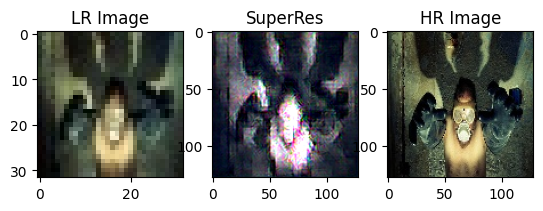

In [20]:
import random

n = random.choice(range(N_data))
print(n)
gen_img = gen.predict(lr_tens[n-1])
plt.subplot(131)
plt.title('LR Image')
plt.imshow(lr_tens[n-1][0,:,:,:])
plt.subplot(132)
plt.title('SuperRes')
plt.imshow(gen_img[0,:,:,:])
plt.subplot(133)
plt.title('HR Image')
plt.imshow(hr_tens[n-1][0,:,:,:])

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


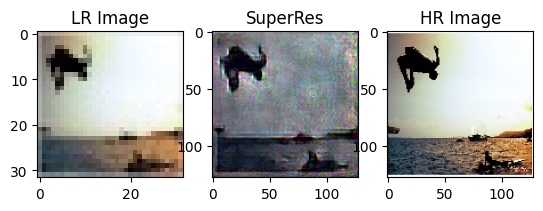

In [21]:
# Feel free to test on images of your own
img = plt.imread(#Insert image) / 255
img2 = plt.imread(#Insert image) / 255
img_tens = tf.convert_to_tensor(img, dtype=float)
img_tens = tf.reshape(img_tens, (-1, 32, 32, 3))
img2_tens = tf.convert_to_tensor(img2, dtype=float)
img2_tens = tf.reshape(img2_tens, (-1, 128, 128, 3))
gen_img = gen.predict(img_tens)
plt.subplot(131)
plt.title('LR Image')
plt.imshow(img_tens[0,:,:,:])
plt.subplot(132)
plt.title('SuperRes')
plt.imshow(gen_img[0,:,:,:])
plt.subplot(133)
plt.title('HR Image')
plt.imshow(img2_tens[0,:,:,:])